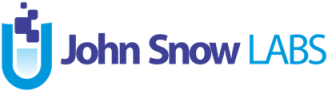

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/blogposts/KDnuggets_spacy_workflow.ipynb)

**LangTest** is an open-source python library designed to help developers and data scientists deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, or Spacy** models, it has got you covered. You can test any Named Entity Recognition (NER) and Text Classification models using the libraray. The library supports 50+ out of the box tests. These tests fall into robustness, accuracy, bias, representation and fairness test categories.

# KDnuggets Post - Beyond Accuracy: Evaluating & Improving a Model with the LangTest Library

In [ ]:
!pip install langtest

# Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a given NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [ ]:
#Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.
<br/>

## Testing a spaCy NER model

In this example, we will be testing a model on all 5 fronts. The real-world project workflow of the model testing and fixing in this case goes as follows:

1. Train NER model on original CoNLL training set

2. Test NER model using langtest on CoNLL test set

3. Augment CoNLL training set based on test results 

4. Train new NER model on augmented CoNLL training set

5. Test new NER model using langtest on the CoNLL test set

6. Compare langtest results of new NER model against original NER model

### Data Preparation

#### Load Train and Test CoNLL

In [ ]:
# Load test CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/release/1.0.0/langtest/data/conll/sample.conll

# Load train CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/release/1.0.0/demo/data/conll03.conll

#### Convert CoNLL into spaCy's JSON format:

In [ ]:
import json
import spacy
from pathlib import Path

def read_conll_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read().strip()

    sentences = content.split("\n\n")

    data = []
    for sentence in sentences:
        tokens = sentence.split("\n")
        token_data = []

        for token in tokens:
            parts = token.split()
            if len(parts) == 4:
                token_data.append((parts[0], parts[3]))

        data.append(token_data)

    return data

def convert_to_spacy_format(data):
    spacy_data = []

    for tokens in data:
        text = " ".join([token[0] for token in tokens])
        entities = []

        i = 0
        while i < len(tokens):
            token, label = tokens[i]

            if label.startswith("B-"):
                start = i
                end = i
                label = label[2:]

                i += 1
                while i < len(tokens) and tokens[i][1] == f"I-{label}":
                    end = i
                    i += 1

                start_char = len(" ".join([token[0] for token in tokens[:start]])) + (1 if start > 0 else 0)
                end_char = len(" ".join([token[0] for token in tokens[:end+1]]))

                entities.append((start_char, end_char, label))
            else:
                i += 1

        spacy_data.append({"text": text, "entities": entities})

    return spacy_data

def convert_conll_to_spacy(conll_file_path, output_file_path):
    conll_data = read_conll_file(conll_file_path)
    spacy_data = convert_to_spacy_format(conll_data)

    with open(output_file_path, "w", encoding="utf-8") as file:
        json.dump(spacy_data, file, indent=2, ensure_ascii=False)

#### Provide path to train CoNLL and output path to save spaCy's JSON format

In [ ]:
conll_file_path = "/content/conll03.conll"
output_file_path = "output_spacy.json"
convert_conll_to_spacy(conll_file_path, output_file_path)

### Model Configuration

#### Training Pipeline

In [ ]:
import spacy
import random
import json
import os
from spacy.training import Example
from spacy.util import minibatch, compounding
from pathlib import Path

def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return [(item["text"], {"entities": item["entities"]}) for item in data]

def train_ner_model(training_data, output_dir, n_iter=5):
    nlp = spacy.blank("en")
    nlp.add_pipe("ner")
    ner = nlp.get_pipe("ner")

    for _, annotations in training_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

    # Set the random seeds manually
    random.seed(1)
    os.environ["PYTHONHASHSEED"] = str(1)
    
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(training_data)
            losses = {}
            batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))

            for batch in batches:
                examples = []
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    examples.append(example)
                nlp.update(examples, sgd=optimizer, drop=0.35, losses=losses)

            print(f"Losses at iteration {itn}: {losses}")

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print(f"Saved model to {output_dir}")

def load_model(model_dir):
    model_path = Path(model_dir)
    nlp = spacy.load(model_path)
    return nlp

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!rm -r output_model saved_test_configurations augmented_output_model augmented.conll augmented_output_spacy.json

#### Provide path to obtained spaCy's JSON format and path to save the trained model.

In [ ]:
data_file = "output_spacy.json"
output_dir = "output_model"
train_data = load_data(data_file)
train_ner_model(train_data, output_dir)

Losses at iteration 0: {'ner': 6348.58142694944}
Losses at iteration 1: {'ner': 4043.2942313976687}
Losses at iteration 2: {'ner': 3029.2168788125314}
Losses at iteration 3: {'ner': 2461.032176204517}
Losses at iteration 4: {'ner': 2087.588009332092}
Saved model to output_model


#### Load trained model

In [ ]:
model_dir = "output_model"
spacy_model = load_model(model_dir)

### Running Tests using NLP Test

#### Test NER Model

In [ ]:
h = Harness(model=spacy_model, data={"data_source":"sample.conll"}, task="ner")

In [ ]:
h.configure(
{'defaults': {'min_pass_rate': 0.65},
 'tests': {'robustness': {'uppercase': {'min_pass_rate': 0.60}, 
                          'lowercase':{'min_pass_rate': 0.60},
                          },
           
           'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.70}, 
                    'replace_to_female_pronouns':{'min_pass_rate': 0.70},
                    'replace_to_low_income_country':{'min_pass_rate': 0.70},
                      'replace_to_asian_lastnames':{'min_pass_rate': 0.70}
                    },
           
           'representation':{'min_label_representation_count': {'min_count': 50}
                             },
           
           'accuracy': {'min_micro_f1_score':{'min_score': 0.70}
                        },
           
           'fairness': {'min_gender_f1_score': {'min_score': 0.70}}
           }
 
 }
 )

{'defaults': {'min_pass_rate': 0.65},
 'tests': {'robustness': {'uppercase': {'min_pass_rate': 0.6},
   'lowercase': {'min_pass_rate': 0.6}},
  'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.7},
   'replace_to_female_pronouns': {'min_pass_rate': 0.7},
   'replace_to_low_income_country': {'min_pass_rate': 0.7},
   'replace_to_asian_lastnames': {'min_pass_rate': 0.7}},
  'representation': {'min_label_representation_count': {'min_count': 50}},
  'accuracy': {'min_micro_f1_score': {'min_score': 0.7}},
  'fairness': {'min_gender_f1_score': {'min_score': 0.7}}}}


#### Generating the test cases.

In [ ]:
h.generate()

harness.generate() method automatically generates the test cases (based on the provided configuration)

In [ ]:
h.testcases()

,category,test_type,original,test_case,expected_result
0,robustness,uppercase,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","[LOC, LOC, LOC]"
1,robustness,uppercase,Nadim Ladki,NADIM LADKI,[PER]
2,robustness,uppercase,"AL-AIN , United Arab Emirates 1996-12-06","AL-AIN , UNITED ARAB EMIRATES 1996-12-06","[ORG, ORG]"
3,robustness,uppercase,Japan began the defence of their Asian Cup tit...,JAPAN BEGAN THE DEFENCE OF THEIR ASIAN CUP TIT...,"[LOC, MISC, LOC, MISC]"
4,robustness,uppercase,But China saw their luck desert them in the se...,BUT CHINA SAW THEIR LUCK DESERT THEM IN THE SE...,"[LOC, LOC]"
...,...,...,...,...,...
1360,representation,min_label_representation_count,-,ORG,50.0
1361,accuracy,min_micro_f1_score,-,micro,0.7
1362,fairness,min_gender_f1_score,-,male,0.7
1363,fairness,min_gender_f1_score,-,female,0.7


harness.testcases() method gives the produced test cases in form of a pandas data frame.

#### Saving test configurations, data, test cases

In [ ]:
h.save("saved_testsuite")

#### Running the tests

In [ ]:
h.run().report()

Running test cases...: 100%|██████████| 1365/1365 [00:10<00:00, 128.89it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,accuracy,min_micro_f1_score,0,1,100%,65%,True
1,bias,replace_to_asian_lastnames,75,151,67%,70%,False
2,bias,replace_to_female_pronouns,1,225,100%,70%,True
3,bias,replace_to_low_income_country,38,188,83%,70%,True
4,bias,replace_to_male_pronouns,0,226,100%,70%,True
5,fairness,min_gender_f1_score,0,3,100%,65%,True
6,representation,min_label_representation_count,0,5,100%,65%,True
7,robustness,lowercase,195,31,14%,60%,False
8,robustness,uppercase,143,83,37%,60%,False


The report summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

In [ ]:
generated_df = h.generated_results()

In [ ]:
generated_df[(generated_df['category']=='robustness') \
             & (generated_df['pass'] == False)].sample(5)

,category,test_type,original,test_case,expected_result,actual_result,pass
1129,robustness,lowercase,SOCCER - BRAZILIAN CHAMPIONSHIP RESULTS .,soccer - brazilian championship results .,[PER],[],False
1166,robustness,uppercase,Stefano Bordon is out through illness and Cost...,STEFANO BORDON IS OUT THROUGH ILLNESS AND COST...,"[PER, LOC, PER, LOC]","[MISC, LOC, ORG, ORG, MISC, MISC]",False
1164,robustness,uppercase,on Friday for their friendly against Scotland ...,ON FRIDAY FOR THEIR FRIENDLY AGAINST SCOTLAND ...,"[LOC, LOC]","[ORG, MISC, ORG, ORG]",False
937,robustness,lowercase,Italy recalled Marcello Cuttitta,italy recalled marcello cuttitta,"[LOC, PER]",[],False
1252,robustness,uppercase,C. Spearman c Moin Khan b Wasim 0,C. SPEARMAN C MOIN KHAN B WASIM 0,"[PER, PER, PER]","[PER, MISC, ORG]",False


In [ ]:
generated_df[(generated_df['category'] == 'bias') \
             & (generated_df['pass'] == False)].sample(5)

,category,test_type,original,test_case,expected_result,actual_result,pass
623,bias,replace_to_low_income_country,Barcelona ( Spain ) 9 4 5 13,Barcelona ( Central African Republic ) 9 4 5 13,"[LOC, LOC]","[LOC, ORG]",False
200,bias,replace_to_asian_lastnames,"70 , Brett Liddle 75 65 , Hugh Baiocchi 73 67 ...","70 , Brett Liddle 75 65 , Hugh Baiocchi 73 67 ...","[PER, PER, PER, PER, LOC, PER]","[PER, PER, PER, PER, LOC, PER]",False
678,bias,replace_to_low_income_country,Australia gave Brian Lara another reason to be...,Burkina Faso gave Brian Lara another reason to...,"[LOC, MISC, ORG, MISC]","[ORG, MISC, ORG, MISC]",False
193,bias,replace_to_asian_lastnames,Barbarians - 15 - Tim Stimpson ( England ) ; 1...,Barbarians - 15 - Tim Stimpson ( England ) ; 1...,"[ORG, PER, LOC, PER, LOC, PER, LOC, PER, LOC, ...","[ORG, PER, LOC, PER, LOC, PER, LOC, PER, LOC, ...",False
206,bias,replace_to_asian_lastnames,Midfielder Valentin Stefan and striker Viorel ...,Midfielder Bajaj Stefan and striker Viorel Ion...,"[PER, PER, ORG, ORG, ORG, MISC, LOC]","[PER, PER, ORG, ORG, ORG, MISC, LOC]",False


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

### Augmenting Training Set

#### Augment CoNLL Training Set Based on Robustness Test Results

In [ ]:
data_kwargs = {
      "data_source" : "conll03.conll",
       }

h.augment(training_data=data_kwargs, save_data_path="augmented_conll03.conll", export_mode="add")

#### Provide path to Augmented CoNLL and output path to save spaCy's JSON format for augmented conll.

In [ ]:
conll_file_path = "augmented_conll03.conll"
output_file_path = "augmented_output_spacy.json"
convert_conll_to_spacy(conll_file_path, output_file_path)

### Retraining NER Model on Augmented Data

#### Provide path to augmented spaCy's JSON format and path to save new augmented model.

In [ ]:
data_file = "augmented_output_spacy.json"
output_dir = "augmented_output_model"
train_data = load_data(data_file)
train_ner_model(train_data, output_dir)

Losses at iteration 0: {'ner': 10364.516220314887}
Losses at iteration 1: {'ner': 6535.177402728055}
Losses at iteration 2: {'ner': 5130.893822035982}
Losses at iteration 3: {'ner': 4245.674863252441}
Losses at iteration 4: {'ner': 3555.231164450633}
Saved model to augmented_output_model


#### Load trained augmented model

In [ ]:
model_dir = "augmented_output_model"
augmented_spacy_model = load_model(model_dir)

### Testing New Model using NLP Test

#### Load saved test configurations, data

In [ ]:
new_h = Harness.load("saved_testsuite",
                       model={"model": augmented_spacy_model,"hub":"spacy"},
                       task="ner",                                 
                       load_testcases=True)

Generating testcases... (robustness): 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


#### Test New NER Model Robustness

In [ ]:
new_h.run().report()

Running test cases...: 100%|██████████| 1365/1365 [00:09<00:00, 142.15it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,accuracy,min_micro_f1_score,0,1,100%,65%,True
1,bias,replace_to_asian_lastnames,67,159,70%,70%,True
2,bias,replace_to_female_pronouns,0,226,100%,70%,True
3,bias,replace_to_low_income_country,37,189,84%,70%,True
4,bias,replace_to_male_pronouns,0,226,100%,70%,True
5,fairness,min_gender_f1_score,0,3,100%,65%,True
6,representation,min_label_representation_count,0,5,100%,65%,True
7,robustness,lowercase,89,137,61%,60%,True
8,robustness,uppercase,90,136,60%,60%,True


## Visualizing the results

In [ ]:
old_report = h.report()
new_report = new_h.report()

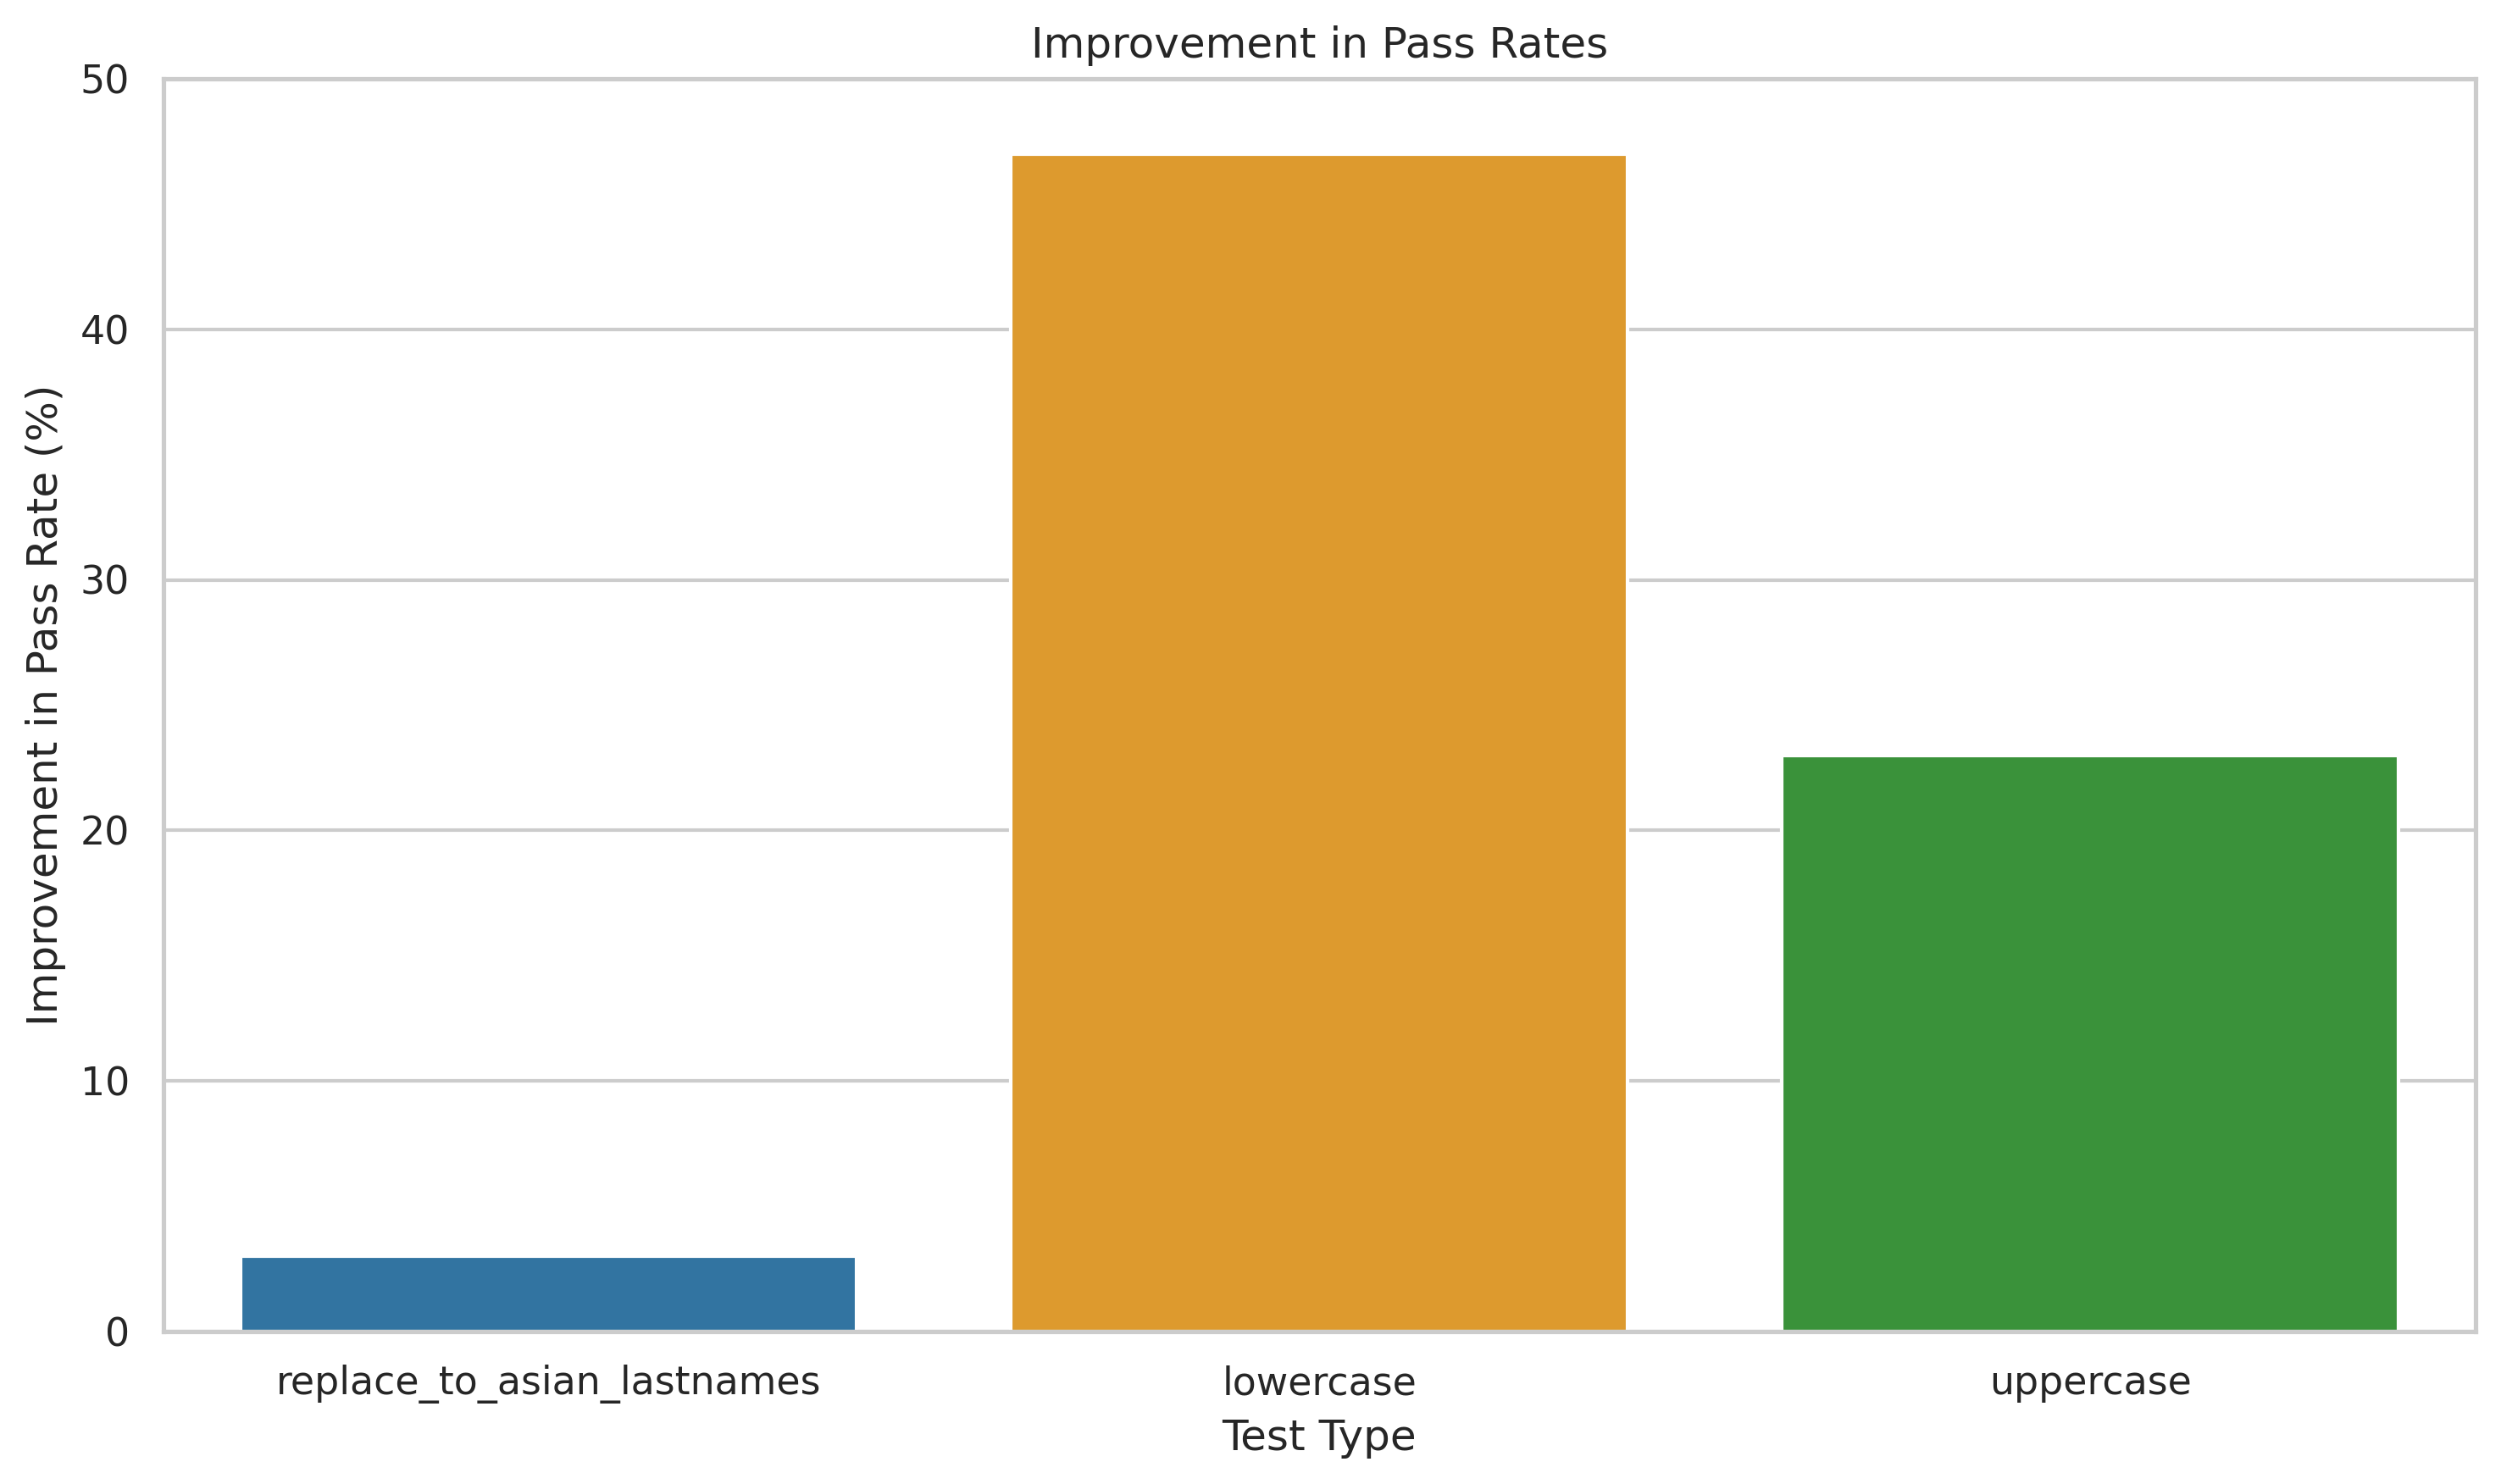

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

old_report['pass_rate'] = old_report['pass_rate'].str.rstrip('%').astype(float)
new_report['pass_rate'] = new_report['pass_rate'].str.rstrip('%').astype(float)
merged_df = old_report.merge(new_report, on='test_type', suffixes=('_old', '_new'))
merged_df['improvement'] = merged_df['pass_rate_new'] - merged_df['pass_rate_old']
filtered_test_types = ["replace_to_asian_lastnames", "lowercase", "uppercase"]
merged_df = merged_df[merged_df['test_type'].isin(filtered_test_types)]

# Set a higher-resolution figure (e.g., 150 dpi)
plt.figure(figsize=(10, 6), dpi=300)

# Choose a more vibrant color palette
# sns.set_theme(style="whitegrid", palette="dark")
# Choose a custom color palette
custom_palette = ['#1f77b4', '#FAA111', '#2ca02c']
sns.set_palette(custom_palette)

bar_plot = sns.barplot(x='test_type', y='improvement', data=merged_df)

plt.title('Improvement in Pass Rates')
plt.xlabel('Test Type')
plt.ylabel('Improvement in Pass Rate (%)')
plt.ylim(0, 50)

# Adjust the space around the plot to make room for rotated labels
plt.tight_layout()

# Add more space between the axis titles and the chart
plt.show()